In [ ]:
import pandas as pd

# Load datasets
df = pd.read_csv('/content/unique_dataset3.csv')

# Display the first few rows of each dataset
print("Dataset :")
print(df.head(20))

Dataset :
                                            statement  label
0   Tanzanian club spokesman Haji S. Manara was in...      0
1   “Dr. Fauci sat on Microsoft’s board of directo...      0
2   NEWS! UK safe from coronavirus as Boris Johnso...      0
3   Does vaping reduce your chances of getting the...      0
4   WHO @eu_echo @Canada &amp; @DFID_UK joined for...      1
5   @d_s_thakur @CDSCO_INDIA_INF @spkalantri Sir i...      0
6   Anyone interested in rise of fascism globally ...      0
7   1980's Rock Group "The Knack" Make Come Back w...      0
8   Situation is 😭. #CoronaInPakistan https://t.co...      0
9   Public Health Professionals: Need #COVID19 res...      1
10  Our daily update is published. We’ve now track...      1
11  A 28-year-old doctor from Maharashtra Dr. Mane...      0
12  A study of 265 patients at the Central Hospita...      1
13  VTE risk is ~ 50% lower in patients with RA ta...      1
14  New daily deaths held steady at 1182 about as ...      1
15  A @Target 

In [ ]:
df

,statement,label
0,Tanzanian club spokesman Haji S. Manara was in...,0
1,“Dr. Fauci sat on Microsoft’s board of directo...,0
2,NEWS! UK safe from coronavirus as Boris Johnso...,0
3,Does vaping reduce your chances of getting the...,0
4,WHO @eu_echo @Canada &amp; @DFID_UK joined for...,1
...,...,...
12123,There are 54 people linked to the community cl...,1
12124,WHO director overstated COVID-19 fatality rate...,0
12125,Through the allocation framework COVAX will en...,1
12126,“Pope Francis says covid vaccine will now be r...,0


In [ ]:
 !pip install pytorch-transformers
 !pip install transformers
 !pip install nltk
 import nltk
 nltk.download('punkt')
 nltk.download('wordnet')
 nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install tweet-preprocessor


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import preprocessor as p

from transformers import XLMModel, BertTokenizer, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import AdamW
import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
p.set_options(p.OPT.URL, p.OPT.EMOJI)

def preprocess(row):
    text = row['statement']
    # text = text.strip('\xa0')
    text = p.clean(text)
    tokenization = nltk.word_tokenize(text)
    return text

In [ ]:
import re
import nltk
from bs4 import BeautifulSoup
# Function to remove HTML contents
def remove_html(statement):
    soup = BeautifulSoup(statement, "html.parser")
    return soup.get_text()






def remove_urls(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+', re.IGNORECASE)
    return url_pattern.sub(r'', text)



def remove_http_and_following(text):
    # Compile the regex pattern
    pattern = re.compile(r'http.*', re.IGNORECASE)
    # Substitute the matched text with an empty string
    return pattern.sub('', text)

# Function to remove hashtags and mentions
def remove_hashtags_mentions(text):
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    return text

# Function to remove special characters and HTML entities
def clean_text(text):
    # Remove HTML entities
    text = BeautifulSoup(text, "html.parser").text
    # Remove special characters and extra spaces
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text



# Apply the cleaning and URL removal functions on the 'statement' column of Dataset2
df['statement'] = df['statement'].apply(remove_urls)
df['statement'] = df['statement'].apply(remove_html)
df['statement'] = df['statement'].apply(remove_http_and_following)
df['statement'] = df['statement'].apply(clean_text)
df['statement'] = df['statement'].apply(remove_hashtags_mentions)


<ipython-input-8-e2f84b9cc0f3>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(statement, "html.parser")
<ipython-input-8-e2f84b9cc0f3>:35: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").text


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Split the dataset into 70% training and 30% remaining
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the remaining 30% into 50% validation and 50% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_df['statement'] = train_df.apply(preprocess, axis=1)
val_df['statement'] = val_df.apply(preprocess, axis=1)
test_df['statement'] = test_df.apply(preprocess, axis=1)


In [ ]:
train_sentences = train_df.statement.values
val_sentences = val_df.statement.values
test_sentences = test_df.statement.values

train_labels = train_df.label.values
val_labels = val_df.label.values

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
MAX_LEN=80
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [ ]:
train_token_ids,train_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

In [ ]:
batch_size = 32

train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_token_ids, test_attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import os
# Define the directory path
directory_path = '/content/models/'

# Create the directory if it does not exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss for epoch 1: 0.08686063039165579
Validation Accuracy for epoch 1: 0.9404848927875243
Model and weights saved
Confusion Matrix:
[[908  25]
 [ 83 803]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.97      0.94       933
     Class 1       0.97      0.91      0.94       886

    accuracy                           0.94      1819
   macro avg       0.94      0.94      0.94      1819
weighted avg       0.94      0.94      0.94      1819



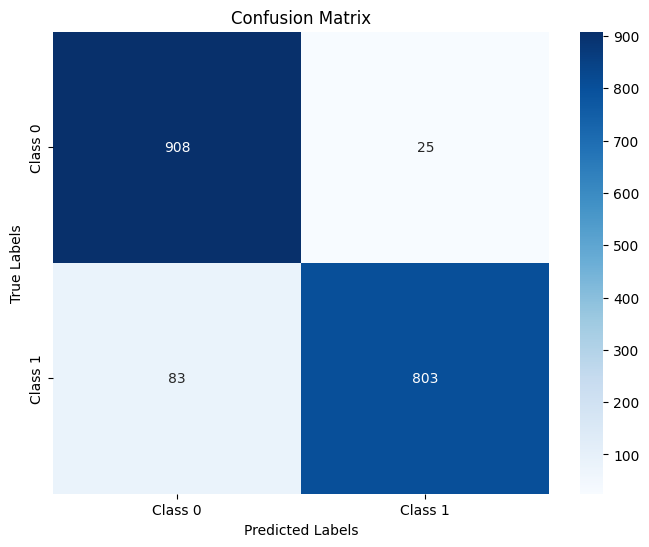

Train loss for epoch 2: 0.05926292378996338
Validation Accuracy for epoch 2: 0.9470638401559454
Model and weights saved
Confusion Matrix:
[[897  36]
 [ 60 826]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.96      0.95       933
     Class 1       0.96      0.93      0.95       886

    accuracy                           0.95      1819
   macro avg       0.95      0.95      0.95      1819
weighted avg       0.95      0.95      0.95      1819



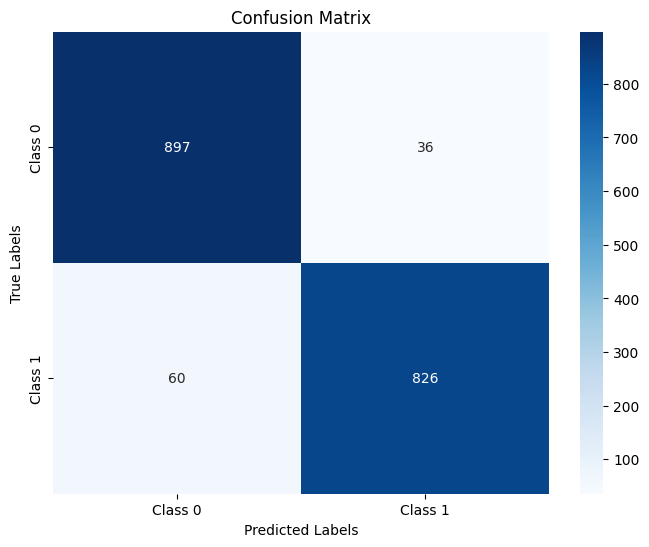

In [ ]:
import os
import torch
from tqdm.notebook import trange  # For progress bar
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize variables
train_loss_set = []
best_val_accuracy = 0.90
directory_path = '/content/models/'  # Update this path as needed
epochs = 2

# Create the directory if it does not exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Training loop
for epoch in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print(f"Train loss for epoch {epoch + 1}: {tr_loss / nb_tr_steps}")

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    all_preds = []
    all_labels = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy

        # Collect predictions and labels for confusion matrix and classification report
        preds = np.argmax(logits, axis=1)
        all_preds.extend(preds)
        all_labels.extend(label_ids)

        nb_eval_steps += 1

    print(f"Validation Accuracy for epoch {epoch + 1}: {eval_accuracy / nb_eval_steps}")
    Validation_Accuracy = eval_accuracy / nb_eval_steps
    if Validation_Accuracy >= best_val_accuracy:
        model_save_path = os.path.join(directory_path, 'ROBERTA_base_uncased_best_model.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': tr_loss / nb_tr_steps,
        }, model_save_path)
        best_val_accuracy = Validation_Accuracy
        print('Model and weights saved')

    # Print confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])  # Adjust class names as needed

    print("Confusion Matrix:")
    print(conf_matrix)

    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
# Prepare test sentences
sentences = [
    'New daily deaths held steady at 1182 about as many as yesterday New York continues to dominate the movement of these numbers and New Yorks numbers have flattened  ',
    'A Target spokesperson said the company plans to continue Heroes  Helpers an event that pairs underserved children with officers to shop for holiday gifts The company says careful considerations are underway on how to manage the event amid COVID19 ',
    'IndiaFightsCorona India registers a record number of high recoveries More than 94000 recovered in last 24 hours Indias total recoveries continue to rise cross 43 lakh today Details ',
    '_A claim that Indias Ministry of Home Affairs has made it a punishable offense for citizens to publish posts on social media about the novel coronavirus has been shared repeatedly on Facebook Twitter and WhatsApp_',
    'A scientific study shows that cannabis is more effective at preventing and treating COVID-19 than hydroxychloroquine.'
]

# Tokenize and encode test sentences
token_ids, attention_masks = get_TokenizedTextWithAttentionMask(sentences, tokenizer)
token_ids = torch.tensor(token_ids)
attention_masks = torch.tensor(attention_masks)

# Create DataLoader for predictions
test_data = TensorDataset(token_ids, attention_masks)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=1)

# Make predictions
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for t in batch)
        b_input_ids, b_input_mask = batch
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs[0]
        predictions.append(logits.cpu().numpy())

# Convert logits to binary predictions
predictions = [1 if p > 0.5 else 0 for p in np.argmax(np.vstack(predictions), axis=1)]

# Print predictions
for i, sentence in enumerate(sentences):
    print(f"The prediction for sentence {i+1} is:", predictions[i])

The prediction for sentence 1 is: 1
The prediction for sentence 2 is: 0
The prediction for sentence 3 is: 1
The prediction for sentence 4 is: 0
The prediction for sentence 5 is: 0
